<a href="https://colab.research.google.com/github/meltem12344/MobileNetV2-Optimization/blob/main/BASE_MobileNetV2_Deney_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## 1️⃣ Kurulum & GPU

In [ ]:
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q',
                        'torch', 'torchvision', 'matplotlib', 'seaborn', 'scikit-learn', 'Pillow', 'timm'])

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'📍 Device: {device}')
if torch.cuda.is_available():
    print(f'🎮 GPU: {torch.cuda.get_device_name(0)}')
else:
    print('⚠️ GPU yok!')


📍 Device: cuda
🎮 GPU: Tesla T4


---
## 2️⃣ Google Drive Bağla

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print('✅ Drive bağlandı!')


Mounted at /content/drive
✅ Drive bağlandı!


---
## 3️⃣ Dataset Yolu Bul

In [ ]:
import os

dataset_dir = None
for root, dirs, files in os.walk('/content/drive/MyDrive'):
    tomato_dirs = [d for d in dirs if d.startswith('Tomato__')]
    if len(tomato_dirs) >= 5:
        dataset_dir = root
        break

if dataset_dir:
    print(f'✅ Dataset: {dataset_dir}')
    classes = sorted([d for d in os.listdir(dataset_dir)
                      if os.path.isdir(os.path.join(dataset_dir, d))])
    print(f'\n📂 Sınıf sayısı: {len(classes)}')
    for i, c in enumerate(classes):
        count = len(os.listdir(os.path.join(dataset_dir, c)))
        print(f'   {i+1:2d}. {c:50s} → {count:4d} görüntü')
else:
    print('❌ Dataset bulunamadı!')


✅ Dataset: /content/drive/MyDrive/Tarım Teknolojileri Yarışması/TomatoDataset/TomatoDataset

📂 Sınıf sayısı: 10
    1. Tomato___Bacterial_spot                            →  107 görüntü
    2. Tomato___Early_blight                              →  298 görüntü
    3. Tomato___Late_blight                               →  111 görüntü
    4. Tomato___Leaf_Mold                                 →  400 görüntü
    5. Tomato___Septoria_leaf_spot                        →  106 görüntü
    6. Tomato___Spider_mites Two-spotted_spider_mite      →  121 görüntü
    7. Tomato___Target_Spot                               →   99 görüntü
    8. Tomato___Tomato_Yellow_Leaf_Curl_Virus             →  100 görüntü
    9. Tomato___Tomato_mosaic_virus                       →  109 görüntü
   10. Tomato___healthy                                   →  157 görüntü


---
## 4️⃣ DataLoader Hazırla

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ── Transforms ──
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# ── Full dataset ──
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=None)
class_names  = full_dataset.classes
num_classes  = len(class_names)

# ── Train / Val split ──
train_idx, val_idx = train_test_split(
    range(len(full_dataset)),
    test_size=0.2,
    random_state=42,  # SABITLE - ikisi de aynı split kullansın
    stratify=full_dataset.targets
)

# ── Custom Dataset ──
class TomatoDataset(Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.samples   = [base_dataset.samples[i] for i in indices]
        self.transform = transform
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        from PIL import Image
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = TomatoDataset(full_dataset, train_idx, train_transform)
val_dataset   = TomatoDataset(full_dataset, val_idx,   val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=0)

print(f'📊 Toplam : {len(full_dataset)}')
print(f'🟢 Train  : {len(train_dataset)}')
print(f'🔵 Val    : {len(val_dataset)}')
print(f'🏷️  Sınıf : {num_classes}')


📊 Toplam : 1608
🟢 Train  : 1286
🔵 Val    : 322
🏷️  Sınıf : 10


---
## 5️⃣ MobileNetV2 Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# BASE MOBILENETV2
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Tüm katmanları dondur
for param in model.parameters():
    param.requires_grad = False

# Sadece classifier değiştir
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.last_channel, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes)
)

model = model.to(device)

total    = sum(p.numel() for p in model.parameters())
trainable= sum(p.numel() for p in model.parameters() if p.requires_grad)

print('✅ MobileNetV2 BASE hazır')
print(f'   Toplam param     : {total:,}')
print(f'   Eğitilebilir     : {trainable:,}')
print(f'   Frozen           : {total - trainable:,}')


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 128MB/s]


✅ MobileNetV2 BASE hazır
   Toplam param     : 2,554,378
   Eğitilebilir     : 330,506
   Frozen           : 2,223,872


---
## 6️⃣ Eğitim Fonksiyonları

In [ ]:
import time
from collections import defaultdict

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out  = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, pred = out.max(1)
        correct += pred.eq(labels).sum().item()
        total   += labels.size(0)
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out  = model(imgs)
            loss = criterion(out, labels)
            total_loss += loss.item()
            _, pred = out.max(1)
            correct += pred.eq(labels).sum().item()
            total   += labels.size(0)
    return total_loss / len(loader), 100. * correct / total

def run_phase(model, train_loader, val_loader, device, epochs, lr, name):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=lr,
    momentum=0.9,
    weight_decay=1e-4
    )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    history = defaultdict(list)
    best_val = 0

    print(f'\n═══════ {name} ═══════')
    for ep in range(epochs):
        t0 = time.time()
        tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        vl_loss, vl_acc = validate(model, val_loader, criterion, device)
        scheduler.step()
        elapsed = time.time() - t0

        history['tr_loss'].append(tr_loss)
        history['tr_acc'].append(tr_acc)
        history['vl_loss'].append(vl_loss)
        history['vl_acc'].append(vl_acc)

        star = ''
        if vl_acc > best_val:
            best_val = vl_acc
            torch.save(model.state_dict(), '/content/best_model.pth')
            star = ' ⭐ BEST'

        print(f'  Epoch {ep+1}/{epochs} | Loss: {tr_loss:.4f} | '
              f'Train: {tr_acc:.2f}% | Val: {vl_acc:.2f}% | {elapsed:.0f}s{star}')

    return history

print('✅ Fonksiyonlar hazır')


✅ Fonksiyonlar hazır


---
## 7️⃣ Fase 1 — Sadece Classifier Eğit

In [ ]:
history1 = run_phase(
    model, train_loader, val_loader, device,
    epochs=5, lr=0.001,
    name='FASE 1 — Classifier Only'
)



═══════ FASE 1 — Classifier Only ═══════
  Epoch 1/5 | Loss: 2.1845 | Train: 19.52% | Val: 24.84% | 671s ⭐ BEST
  Epoch 2/5 | Loss: 2.0500 | Train: 25.04% | Val: 27.02% | 84s ⭐ BEST
  Epoch 3/5 | Loss: 1.9420 | Train: 28.69% | Val: 31.68% | 84s ⭐ BEST
  Epoch 4/5 | Loss: 1.8700 | Train: 31.80% | Val: 36.02% | 78s ⭐ BEST
  Epoch 5/5 | Loss: 1.8069 | Train: 35.07% | Val: 38.20% | 74s ⭐ BEST


---
## 8️⃣ Fase 2 — Full Fine-Tune

In [ ]:
# Tüm katmanları aç
for param in model.parameters():
    param.requires_grad = True

history2 = run_phase(
    model, train_loader, val_loader, device,
    epochs=5, lr=0.0001,
    name='FASE 2 — Full Fine-Tune'
)



═══════ FASE 2 — Full Fine-Tune ═══════
  Epoch 1/5 | Loss: 1.7663 | Train: 38.57% | Val: 38.82% | 79s ⭐ BEST
  Epoch 2/5 | Loss: 1.7467 | Train: 39.58% | Val: 41.30% | 79s ⭐ BEST
  Epoch 3/5 | Loss: 1.6945 | Train: 39.81% | Val: 42.24% | 79s ⭐ BEST
  Epoch 4/5 | Loss: 1.6850 | Train: 40.82% | Val: 41.93% | 78s
  Epoch 5/5 | Loss: 1.6547 | Train: 41.68% | Val: 43.79% | 78s ⭐ BEST


---
## 9️⃣ Sonuçlar

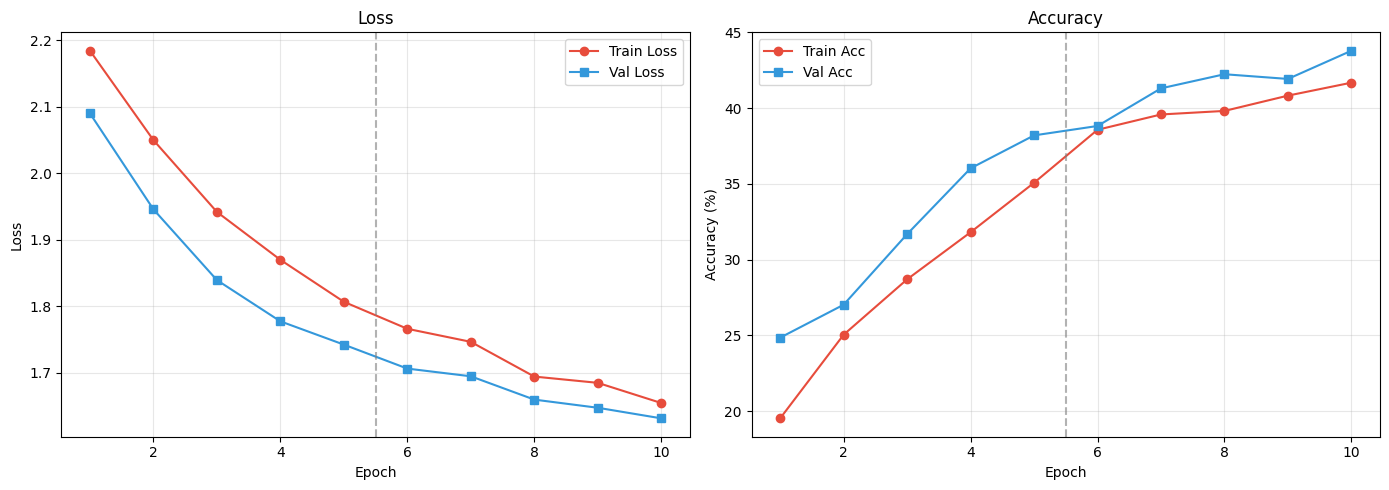


🏆 En İyi Val Accuracy: 43.79%
📊 Final Train Accuracy: 41.68%
📊 Final Val Accuracy: 43.79%


In [ ]:
import matplotlib.pyplot as plt

tr_loss = history1['tr_loss'] + history2['tr_loss']
vl_loss = history1['vl_loss'] + history2['vl_loss']
tr_acc  = history1['tr_acc']  + history2['tr_acc']
vl_acc  = history1['vl_acc']  + history2['vl_acc']

epochs_range = range(1, len(tr_loss) + 1)
fase1_end = len(history1['tr_loss'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs_range, tr_loss, 'o-', color='#e74c3c', label='Train Loss')
ax1.plot(epochs_range, vl_loss, 's-', color='#3498db', label='Val Loss')
ax1.axvline(fase1_end + 0.5, color='gray', linestyle='--', alpha=0.6)
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.set_title('Loss'); ax1.legend(); ax1.grid(True, alpha=0.3)

ax2.plot(epochs_range, tr_acc, 'o-', color='#e74c3c', label='Train Acc')
ax2.plot(epochs_range, vl_acc, 's-', color='#3498db', label='Val Acc')
ax2.axvline(fase1_end + 0.5, color='gray', linestyle='--', alpha=0.6)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy'); ax2.legend(); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training_curves.png', dpi=150)
plt.show()

print(f'\n🏆 En İyi Val Accuracy: {max(vl_acc):.2f}%')
print(f'📊 Final Train Accuracy: {tr_acc[-1]:.2f}%')
print(f'📊 Final Val Accuracy: {vl_acc[-1]:.2f}%')


---
## 🔟 Confusion Matrix

Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.00      0.00      0.00        21
                        Tomato___Early_blight       0.48      0.47      0.47        60
                         Tomato___Late_blight       0.17      0.05      0.07        22
                           Tomato___Leaf_Mold       0.42      0.82      0.56        80
                  Tomato___Septoria_leaf_spot       0.89      0.38      0.53        21
Tomato___Spider_mites Two-spotted_spider_mite       0.32      1.00      0.49        24
                         Tomato___Target_Spot       0.33      0.05      0.09        20
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.05      0.10        20
                 Tomato___Tomato_mosaic_virus       0.80      0.55      0.65        22
                             Tomato___healthy       0.00      0.00      0.00        32

                  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


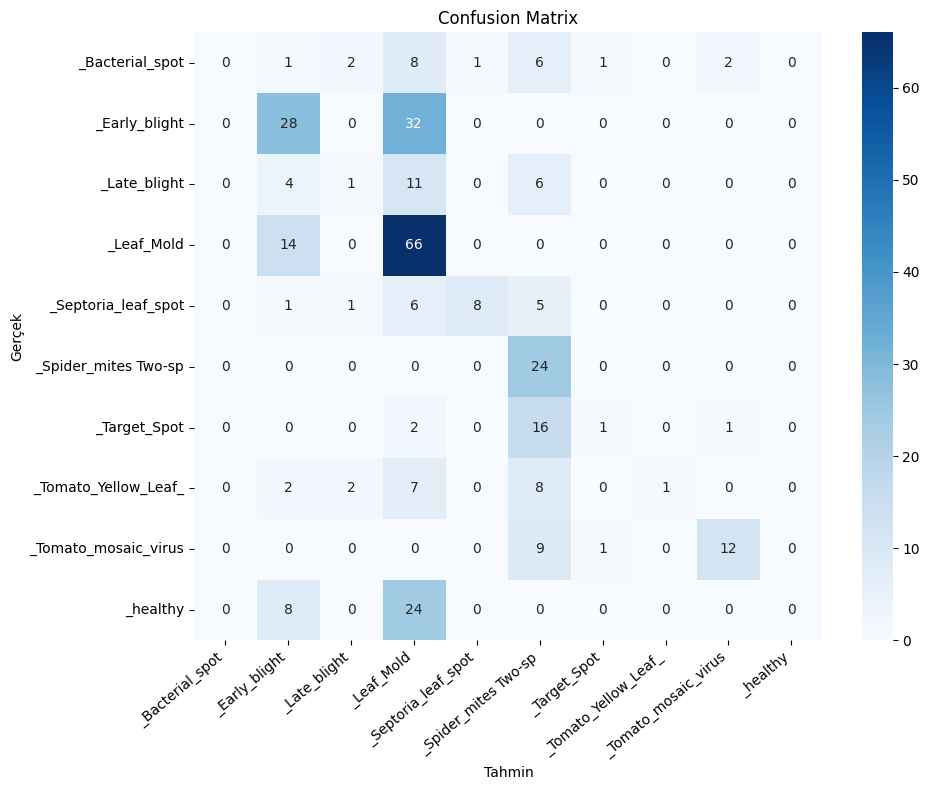

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        out  = model(imgs)
        _, pred = out.max(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.numpy())

print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[n.replace('Tomato__','')[:20] for n in class_names],
            yticklabels=[n.replace('Tomato__','')[:20] for n in class_names])
plt.title('Confusion Matrix')
plt.ylabel('Gerçek'); plt.xlabel('Tahmin')
plt.xticks(rotation=40, ha='right')
plt.tight_layout()
plt.savefig('/content/confusion_matrix.png', dpi=150)
plt.show()


---
## 1️⃣1️⃣ Sonuçları Kaydet

In [ ]:
import json

results = {
    'model': 'MobileNetV2',
    'best_val_acc': float(max(vl_acc)),
    'final_train_acc': float(tr_acc[-1]),
    'final_val_acc': float(vl_acc[-1]),
    'history': {
        'train_loss': [float(x) for x in tr_loss],
        'val_loss': [float(x) for x in vl_loss],
        'train_acc': [float(x) for x in tr_acc],
        'val_acc': [float(x) for x in vl_acc]
    }
}

with open('/content/results_mobilenetv2.json', 'w') as f:
    json.dump(results, f, indent=2)

print('✅ Sonuçlar kaydedildi')
print(f'\n📁 results_mobilenetv2.json dosyası oluşturuldu')


✅ Sonuçlar kaydedildi

📁 results_mobilenetv2.json dosyası oluşturuldu
